In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from msapy import plottings as pl
import matplotlib.pyplot as plt

import seaborn as sns
import utils as ut
import pandas as pd
import netneurotools.datasets
from scipy.stats import pearsonr
import warnings
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid


In [3]:
SEED = 2023
pl.set_style(font_size=8)
CM = 1/2.54

DEEP_BLUE = '#006685'
BLUE = '#3FA5C4'
WHITE = '#FFFFFF'
HALF_BLACK = '#232324'
ORANGE = '#E84653'
RED= '#BF003F'

PURPLE = '#A6587C'
PURPLER = '#591154'
PURPLEST = '#260126'
NIGHT_BLUE = '#394D73'
YELLOW = '#E6B213'


from_white = [DEEP_BLUE, BLUE, WHITE, ORANGE, RED]
white_to_reds = [WHITE, ORANGE, RED]
white_to_blues = [WHITE, BLUE, DEEP_BLUE]

black_to_reds = [HALF_BLACK, ORANGE, RED]
black_to_blues = [HALF_BLACK, BLUE, DEEP_BLUE]

from_black = [DEEP_BLUE,BLUE,HALF_BLACK,ORANGE,RED]



diverge_from_white = sns.blend_palette(from_white,as_cmap=True)
diverge_from_black = sns.blend_palette(from_black,as_cmap=True)

white_red_mono = sns.blend_palette(white_to_reds,as_cmap=True)
white_blue_mono = sns.blend_palette(white_to_blues,as_cmap=True)

black_red_mono = sns.blend_palette(black_to_reds,as_cmap=True)
black_blue_mono = sns.blend_palette(black_to_blues,as_cmap=True)

purple_red = sns.blend_palette([PURPLEST, PURPLE, RED])

In [4]:
human = netneurotools.datasets.fetch_connectome('human_struct_scale125')
human_fc = netneurotools.datasets.fetch_connectome('human_func_scale125')['conn']
np.fill_diagonal(human_fc,0)

In [73]:
#connectivity = ut.spectral_normalization(1,human['conn'])
connectivity = human['conn']/human['conn'].max()
n_nodes = len(connectivity)

In [178]:
warnings.filterwarnings("ignore")

rng = np.random.default_rng(seed=SEED)
delta = 0.01
tau = 0.02
G =0.4
timesteps = 500
#timesteps = int(100/delta)
#W = G*human['conn']*delta/tau
noise_strength = 0.05

noise = np.zeros((n_nodes,int(timesteps/delta)+1))
for i in range(int(timesteps/delta)+1):
    noise[:,i] = rng.normal(0,noise_strength,(n_nodes,))

In [179]:



#simple_human_dynamics = ut.differntial_model(adjacency_matrix=connectivity,input_matrix=noise,delta=delta,G=G,tau=tau)

simple_human_dynamics = ut.linear_model(adjacency_matrix=connectivity,coupling=G,dt=delta,duration=timesteps,timescale=tau,input_matrix=noise)


In [131]:
# connectivity = ut.spectral_normalization(1,human['conn'])

# rng = np.random.default_rng(seed=SEED)
# G =0.9
# timesteps = 1000

# noise_strength = 0.05



# noise = np.zeros((n_nodes,timesteps))
# for i in range(timesteps):
#     noise[:,i] = rng.normal(0,noise_strength,(n_nodes,))

# simple_human_dynamics = ut.simple_dynamical_system(adjacency_matrix=human['conn']/human['conn'].max(),
#                                                    input_matrix=noise,
#                                                    coupling=G)


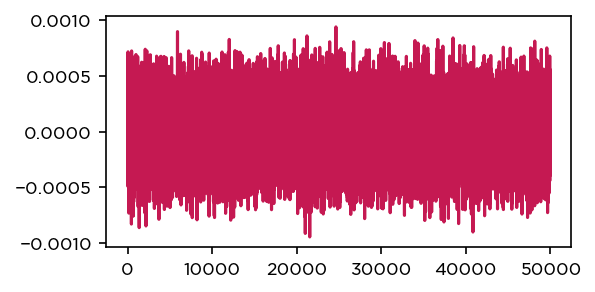

In [180]:
plt.figure(figsize=(4,2),dpi=150)
#plt.plot(noise[-1],alpha=0.6,color=NIGHT_BLUE)
plt.plot(simple_human_dynamics[10],alpha=0.9,color=RED);


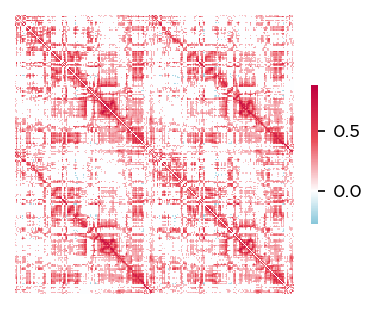

In [9]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(human_fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

In [156]:
parameter_space = list(ParameterGrid({'G':np.linspace(0.01,15,20).round(2,),'tau':np.linspace(0.01,0.1,20).round(2)}))

In [157]:
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    dynamics = ut.linear_model(adjacency_matrix=connectivity,coupling=parameters['G'],dt=delta,duration=timesteps,timescale=parameters['tau'],input_matrix=noise)
    
    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})

optimum_params = max(parameter_space, key=lambda x: x['correlation'])

dynamics = ut.linear_model(adjacency_matrix=connectivity,coupling=optimum_params['G'],dt=delta,duration=timesteps,timescale=optimum_params['tau'],input_matrix=noise)
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc,0)
fc = np.nan_to_num(fc)
optimum_params

Optimizing hyperparams: 100%|██████████| 400/400 [11:50<00:00,  1.78s/it]


{'G': 12.63, 'tau': 0.02, 'correlation': 0.1425789230994119}

In [ ]:
# 'G': 12.63, 'tau': 0.02, 'correlation': 0.142

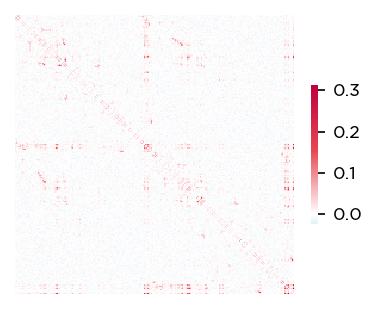

In [159]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

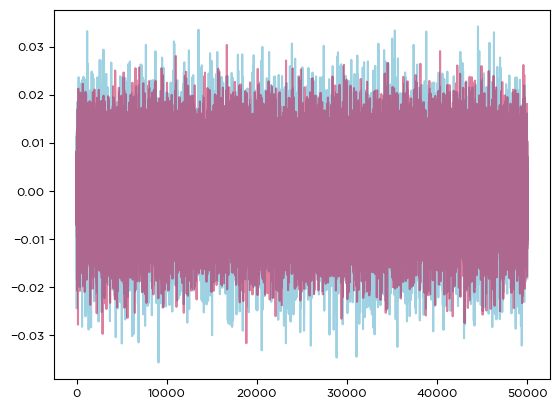

In [160]:
plt.plot(dynamics[-1],alpha=0.5,color=BLUE);
plt.plot(dynamics[0],alpha=0.5,color=RED);

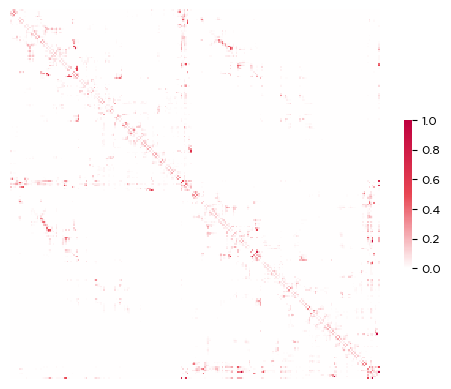

In [68]:
normalized_conn = human['conn']/human['conn'].max()
sns.heatmap(normalized_conn,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

In [69]:
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    dynamics = ut.simple_dynamical_system(adjacency_matrix=normalized_conn,
                                                   input_matrix=noise,
                                                   coupling=parameters['G'])
    fc = np.corrcoef(dynamics)
    np.fill_diagonal(fc,0)
    fc = np.nan_to_num(fc)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r = np.corrcoef(human_fc[np.triu_indices_from(human_fc, k=1)], fc[np.triu_indices_from(fc, k=1)])[0, 1]
        parameters.update({'correlation': r})


Optimizing hyperparams: 100%|██████████| 100/100 [00:17<00:00,  5.71it/s]


In [70]:
optimum_params = max(parameter_space, key=lambda x: x['correlation'])
dynamics = ut.simple_dynamical_system(adjacency_matrix=connectivity,
                                                   input_matrix=noise,
                                                   coupling=optimum_params['G'])
fc = np.corrcoef(dynamics)
np.fill_diagonal(fc,0)
optimum_params

{'G': 0.34, 'correlation': 0.025368808394460048}

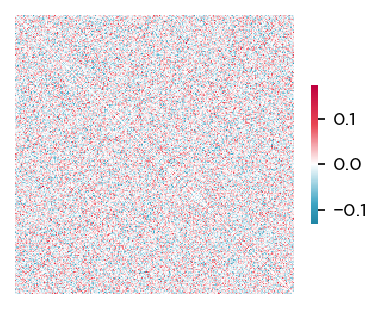

In [71]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

In [43]:
for parameters in tqdm(parameter_space,
                       total=len(parameter_space),
                       desc='Optimizing hyperparams: '):
    dynamics = ut.differntial_model(human['conn'],noise,delta=delta,G=parameters['G'],tau=parameters['tau'])
    fc = np.corrcoef(dynamics[:,::1000])
    np.fill_diagonal(fc,0)
    if fc.mean() > 0.9:
        parameters.update({'correlation': 0})
    else:
        r,_= pearsonr(fc.flatten(),human_fc.flatten())
        parameters.update({'correlation': r})

Optimizing hyperparams: 100%|██████████| 400/400 [07:05<00:00,  1.06s/it]


In [44]:
optimum_params = max(parameter_space, key=lambda x: x['correlation'])
dynamics = ut.differntial_model(connectivity,input,delta=delta,G=optimum_params['G'],tau=parameters['tau'])
fc = np.corrcoef(dynamics[:,::1000])
np.fill_diagonal(fc,0)

In [45]:
optimum_params

{'G': 1.0, 'tau': 5.0, 'correlation': 0.017273794229220474}

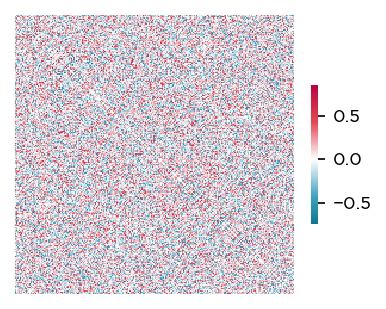

In [68]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

In [69]:
# for parameters in tqdm(parameter_space,
#                        total=len(parameter_space),
#                        desc='Optimizing hyperparams: '):
#     connectivity = human['conn'].copy()
#     connectivity = ut.spectral_normalization(1,connectivity)
#     dynamics = ut.simple_dynamical_system(connectivity,noise,G=parameters['G'])
#     fc = np.corrcoef(dynamics[:,::100])
#     np.fill_diagonal(fc,0)
#     r,_= pearsonr(fc.flatten(),human_fc.flatten())
#     parameters.update({'correlation': r})

Optimizing hyperparams: 100%|██████████| 10/10 [01:32<00:00,  9.21s/it]


In [70]:
# optimum_params = max(parameter_space, key=lambda x: x['correlation'])


# dynamics = dynamics = ut.simple_dynamical_system(connectivity,noise,G=optimum_params['G'])
# fc = np.corrcoef(dynamics[:,::100])
# np.fill_diagonal(fc,0)

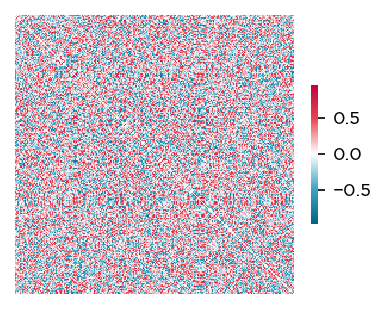

In [46]:
plt.figure(figsize=(3,3),dpi=150)
sns.heatmap(fc,square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);

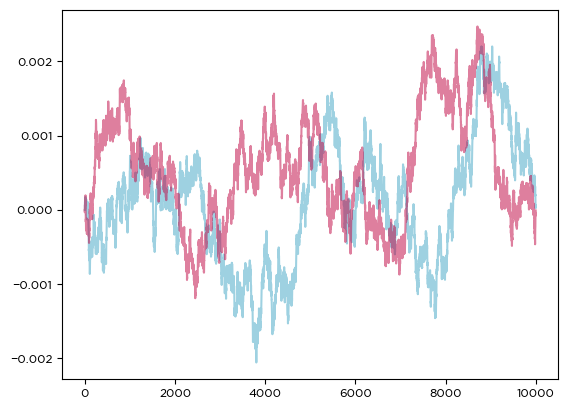

In [47]:
plt.plot(dynamics[0],alpha=0.5,color=BLUE)
plt.plot(dynamics[-1],alpha=0.5,color=RED);

In [44]:
n_nodes = connectivity.shape[0] # number of nodes
t = np.arange(1, 10/delta + 1) # holds time steps
x = np.ndarray((n_nodes, len(t)+1)) # holds variable x
# either use predefined initial conditions or random ones
x[:, :1] = noise[:,0].reshape(-1,1)
noise = np.zeros((n_nodes,timesteps))
for i in range(timesteps):
    noise[:,i] = rng.normal(0,noise_strength,(n_nodes,))
#a = njit_integrate(x, t, tau = 0.05, K = 0.9, N = n_nodes, Cmat=human['conn'], dt=delta, input_matrix=noise)

In [46]:
np.ndarray((n_nodes, len(t)+1))

array([[ 4.64598792e-310,  6.90927535e-310,  4.64598792e-310, ...,
        -1.87685883e-001,  4.99632953e-003,  2.39329018e-001],
       [-9.03702601e-002,  7.96468443e-002, -2.42722056e-001, ...,
         8.87698795e-002, -6.27165238e-002, -2.27792433e-002],
       [ 1.30253167e-002,  7.64530897e-002, -7.68303781e-002, ...,
        -8.76553672e-002,  7.80876879e-003, -1.36660744e-002],
       ...,
       [ 7.45859688e-003, -1.36684068e-002,  1.07051708e-001, ...,
        -1.08287057e-001, -3.23437160e-002,  5.12471588e-002],
       [ 3.73642188e-002,  6.38450285e-002,  9.05805687e-002, ...,
        -6.07778761e-002,  1.95253338e-001,  3.14773679e-002],
       [ 9.19485973e-002,  6.81596181e-002,  1.46709677e-002, ...,
         7.82669411e-002,  1.48002509e-001,  6.79033666e-002]])

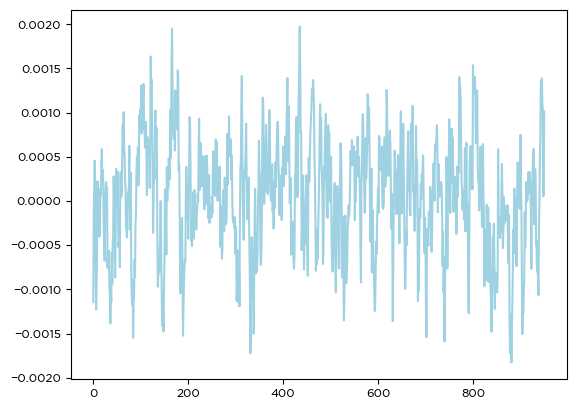

In [40]:
plt.plot(a[0,50:],alpha=0.5,color=BLUE)

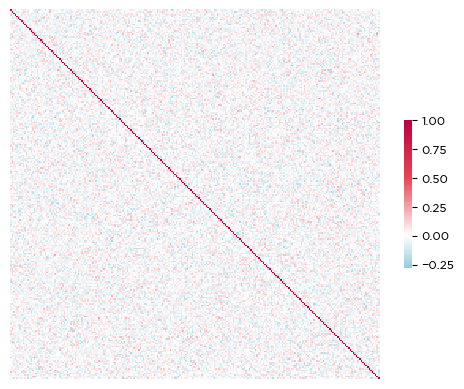

In [43]:
sns.heatmap(np.corrcoef(a[:,50:]),square=True,center=0,cmap=diverge_from_white,cbar_kws={"shrink":.4},linewidths=0.,yticklabels=False,xticklabels=False);